# Add numba
For faster calculation (in progress)

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Nx    = 30
Nt    = 100
T     = 100
D     =  1.1e-8
I     =  None
G     = None
ku    = 1e-20
kd    = 2e-31
ks    = 1e19
L     = 2e-5

Nx**2/Nt

9.0

In [3]:
Nx    = 30
Nt    = 100
T     = 100
D     =  1.1e-8
I     =  None
G     = None
ku    = 1e-31
kd    = 2e-31
ks    = 1e19
L     = 2e-5
Uinit = np.ones(Nx + 1)*5e24*0

G = np.ones(Nt)
G[30:] = 0
G = G * ks


x = np.linspace(0, L, Nx + 1)  # mesh points in space
t = np.linspace(0, T, Nt + 1)  # mesh points in time
if I:
    u_1 = np.array([I(i) for i in x])  # initial concentration
else:
    u_1 = np.copy(Uinit)

dx = x[1] - x[0]
dt = t[1] - t[0]
F = D * dt / dx ** 2
inlet = []
outlet = []
inlet.append(ku * u_1[0] ** 2)
outlet.append(kd * u_1[Nx] ** 2)
u = np.zeros(Nx + 1)

color_idx = np.linspace(0, 1, Nt)
teta1 = D / (ku * dx)
teta2 = D / (kd * dx)


# Solving loops
for n in range(0, Nt):
    # calculate u[1] and u[Nx-1] using explicit stencil
    g0 = F * u_1[0] + (1 - 2 * F) * u_1[1] + F * u_1[2]
    gL = F * u_1[Nx - 2] + (1 - 2 * F) * u_1[Nx - 1] + F * u_1[Nx]
    # put 1 for u[0] and u[Nx-1] in A
    A = diags(
        diagonals=[
            [0] + [-F for i in range(Nx - 1)],
            [1] + [1.0 + 2.0 * F for i in range(Nx - 1)] + [1],
            [-F for i in range(Nx - 1)] + [0],
        ],
        offsets=[1, 0, -1],
        shape=(Nx + 1, Nx + 1),
        format="csr",
    )
    # in the b (for BE) put roots of the quadratic equation for the border.
    b = np.array(
        [-teta1 / 2.0 + 0.5 * np.sqrt(teta1 ** 2 + 4 * teta1 * g0 + 4 * G[n] / ku)]
        + [i for i in u_1[1:Nx]]
        + [-teta2 / 2.0 + 0.5 * np.sqrt(teta2 ** 2 + 4 * teta2 * gL)]
    )
    # solve SLE
    u[:] = spsolve(A, b)
    
    u"Instead of u**2 put u*a, where a - u from previous step"
    for _ in range(3):
        a0 = u[0]
        aL = u[Nx]
        A = diags(
            diagonals=[
                [-D / dx] + [-F for i in range(Nx - 1)],
                [D / dx + ku * a0]
                + [1.0 + 2.0 * F for i in range(Nx - 1)]
                + [D / dx + kd * aL],
                [-F for i in range(Nx - 1)] + [-D / dx],
            ],
            offsets=[1, 0, -1],
            shape=(Nx + 1, Nx + 1),
            format="csr",
        )
        b = np.array([G[n]] + [i for i in u_1[1:Nx]] + [0])
        u[:] = spsolve(A, b)
    u_1, u = u, u_1
    inlet.append(ku * u_1[0] ** 2)
    outlet.append(kd * u_1[Nx] ** 2)

In [4]:
i,j = inlet,outlet

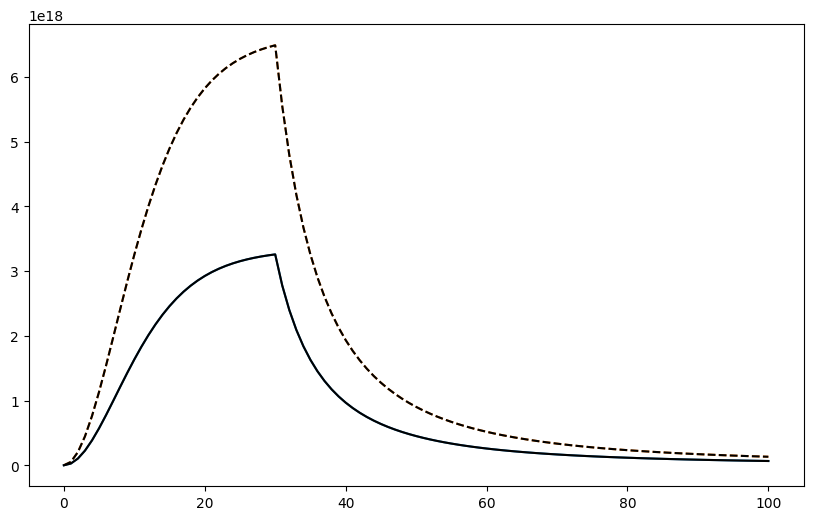

In [6]:
plt.gcf().set_size_inches([10,6])

plt.plot(t,inlet,'-')
plt.plot(t,outlet,'--')
plt.plot(t,i,'k-')
plt.plot(t,j,'k--')

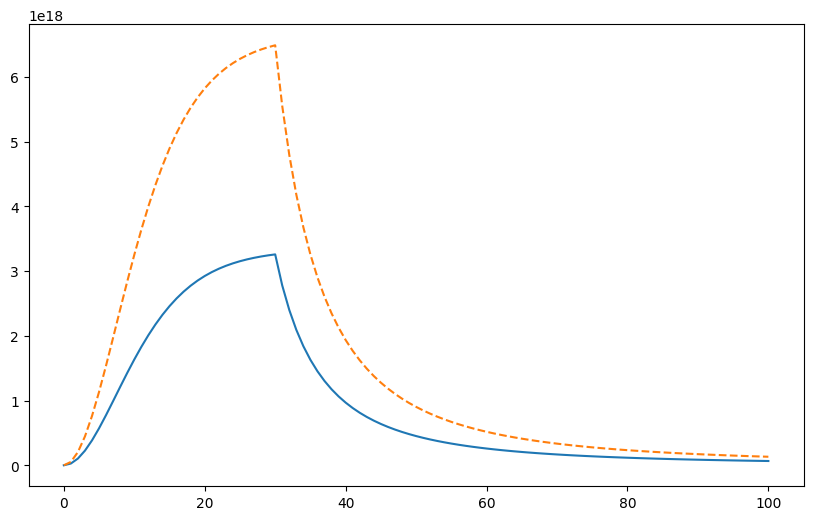

In [7]:
plt.gcf().set_size_inches([10,6])
plt.plot(t,inlet,'-')
plt.plot(t,outlet,'--')